# Homework 3 - Code Outputs

## Allison Collins

## Overview

In this file, I will run my updated pipeline on the kaggle credit dataset. Given the number of thresholds we were asked to compare, I reduced the different values of each of the other parameters from my initial exploration, as I did not see huge differences in performance, to improve the readability and length of this document.

I run each model individually with the associated performance outputs to try to make it clearer given the volume of information. Additionally, the baseline is computed using the sklearn dummy classifier as a baseline metric.

***A few notes and citations: 

-- I consulted lab materials both here and in the pipeline document (specifically for adjusting thresholds & calculations from predicted scores; looping over models modifying parameters; investigating feature importance.) 

--At the end of each section per type of model, I include a chart which has all of the performance metrics across models. The date, threshold, and other (specific to the model) parameter values are included in the leftmost column. 

--I will call out in the different sections some models with better performance; the policy memo will stick to the implications for implementations and avoid too much technical language as per the instructions.

## Data cleaning and processing

We will import the pipeline file and a few other modules we might need in cleaning the data (specific to this dataset and the task at hand).

In [1]:
import pipeline_revised
import pandas as pd
import pydot
import numpy as np

In [2]:
#Read in the data
df = pipeline_revised.read_file('projects_2012_2013.csv')

In [3]:
#Check its contents
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded'],
      dtype='object')

In [4]:
df.head(1)

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13


For this particular dataset, our target variable is time to funding, so we will need to create an additional column which looks at the time required to get full funding (e.g. the difference between date posted and date fully funded, since this is not explicitly included in the dataset).

In [5]:
df['datefullyfunded'] = pd.to_datetime(df.datefullyfunded)
df['date_posted'] = pd.to_datetime(df.date_posted)
df['time_to_funding'] = (df.datefullyfunded - df.date_posted).dt.days
df.head(1)

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,time_to_funding
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,2013-04-14,2013-05-02,18


For this particular dataset, we have a number of categorical columns; in this case, I will opt to drop NAs; with the information we have on hand, it doesn't make sense to impute categories such as a school's focus area or poverty level. I'm subsetting this to columns planned to include in the analysis -- so if there is a na in a different column, we will retain it.

In [6]:
print('Current shape:', df.shape)

Current shape: (124976, 27)


In [7]:
df = df.dropna(axis=0,subset=['time_to_funding','total_price_including_optional_support','students_reached'])
print('New shape:', df.shape)

New shape: (124917, 27)


We can now look at some summary stats for the numerical columns with the cleaned dataset we are going to be working with. We can see that the average time to funding is 48 days, with a median of 41, so it is skewed upwards. The average total price is about 670 dollars, and on averge 90 students are reached.

In [8]:
pipeline_revised.calc_summary_stats(df,cols_to_include=['time_to_funding','total_price_including_optional_support','students_reached'])

,mean,std_dev,median,max_val,min_val
time_to_funding,48.349144,31.997898,41.00,120.00,5.0
total_price_including_optional_support,654.075199,1098.259478,510.51,164382.84,92.0
students_reached,95.445760,163.481912,30.00,12143.00,1.0


In addition, we will have to create a binary outcome "label" column which assigns 1 or 0 based on whether the time to funding was over or under 60. We will also convert a few of the categorical variables to dummy columns so that we can include those in our analysis as well.

In [9]:
#We will convert the time-to-funding column to be binary as required for some of the models
df['time_tf'] = np.where(df['time_to_funding']>=60, 1, 0)

#We will convert a few columns to use in our analysis
df = pipeline_revised.create_binary_col(df, 'eligible_double_your_impact_match', {'t':1,'f':0})
df = pipeline_revised.discretize_categorical(df, ['poverty_level','resource_type','primary_focus_subject','school_metro'])

#Now we can look at columns to grab which we want as predictors
df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_district', 'school_county', 'school_charter', 'school_magnet',
       'teacher_prefix', 'primary_focus_area', 'secondary_focus_subject',
       'secondary_focus_area', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'time_to_funding', 'time_tf',
       'eligible_double_your_impact_match_binary',
       'poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty',
       'resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors', 'primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_foc

Now that the data is in the right format, we will work through the different models and look at their evaluation performance.

We can first start with the decision tree. 

## Decision Tree Classifier

In [11]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
thresholds = [.01,.02,.05,.1,.2,.3,.5]
depth_list = [3, 4]
trees = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for depth in depth_list:
        for threshold in thresholds:
            tree_name = 'tree_' + date + '_' + str(threshold) + '_' + str(depth)
            y_test, y_predict, y_score, features = pipeline_revised.create_decision_tree(df, 'time_tf', depth ,500 ,tree_name, threshold=threshold,
                                                          predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
            
            trees.append((tree_name,y_test,y_predict, y_score, features))


We will create a table which shows the performance of the different iterations of the model.

In [12]:
tree_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(trees)):
    name, test, predict, _, _ = trees[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    tree_metrics.loc[i,'name'] = name
    tree_metrics.loc[i,'accuracy'] = accuracy
    tree_metrics.loc[i,'precision'] = precision
    tree_metrics.loc[i,'auc'] = auc
    tree_metrics.loc[i,'recall'] = recall
    tree_metrics.loc[i,'f1'] = f1

tree_metrics

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,name,accuracy,precision,auc,recall,f1
0,tree_2013-06-30_0.01_3,0.168283,0.168283,0.5,1,0.288087
1,tree_2013-06-30_0.02_3,0.168283,0.168283,0.5,1,0.288087
2,tree_2013-06-30_0.05_3,0.168283,0.168283,0.5,1,0.288087
3,tree_2013-06-30_0.1_3,0.243857,0.179903,0.538117,0.981659,0.30408
4,tree_2013-06-30_0.2_3,0.354909,0.195151,0.575061,0.9069,0.321188
5,tree_2013-06-30_0.3_3,0.55585,0.221265,0.593661,0.650655,0.33023
6,tree_2013-06-30_0.5_3,0.831717,0,0.5,0,0
7,tree_2013-06-30_0.01_4,0.168283,0.168283,0.5,1,0.288087
8,tree_2013-06-30_0.02_4,0.168283,0.168283,0.5,1,0.288087
9,tree_2013-06-30_0.05_4,0.168283,0.168283,0.5,1,0.288087


Some of trees (as will happen with later models) have precision / recall of 0 because they were lacking true positives. Let's visualize the one which has the highest area under the curve.

In [13]:
(graph,) = pydot.graph_from_dot_file('tree_2013-06-30_0.3_4')

In [14]:
graph.write_png('tree_1.png')

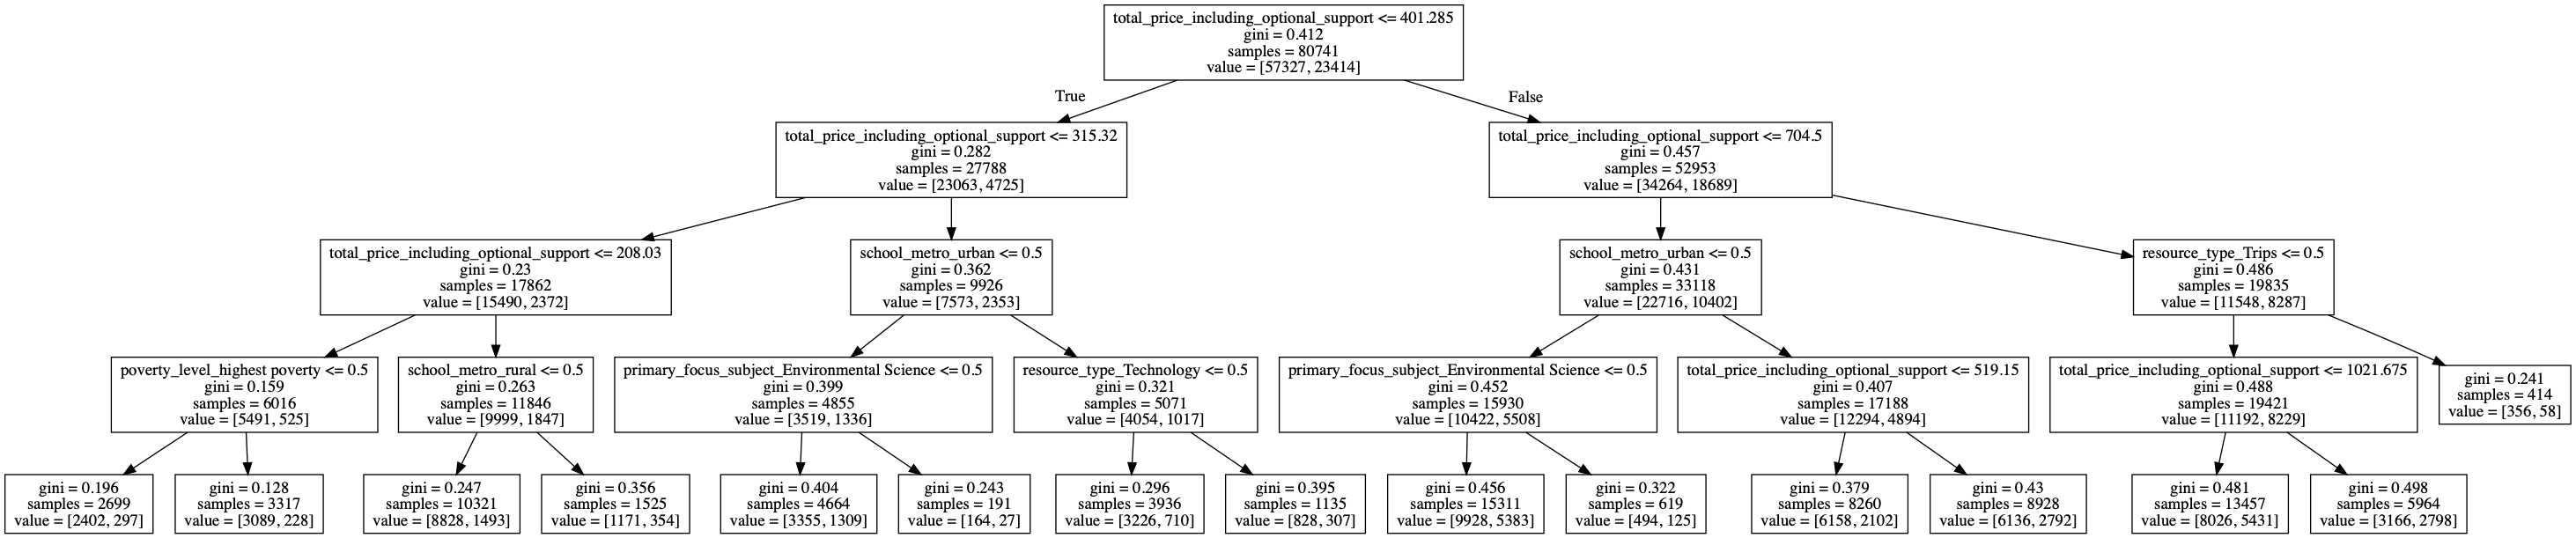

In [15]:
from IPython.display import Image
Image("tree_1.png")

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.21')

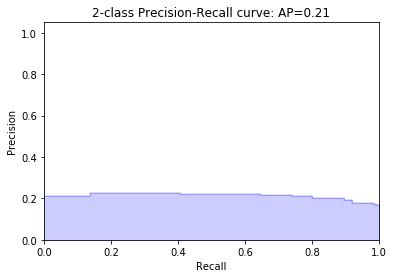

In [16]:
#Citation for precision recall curve - sklearn documentation
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

_, test, _, score, _ = trees[12]
clean_score = [x[1] for x in score]

precision, recall, _ = precision_recall_curve(test, clean_score)
average_precision = average_precision_score(test, clean_score)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

This will be discussed in the policy write-up, but overall the performance across the models will be fairly similar. Investigating model documentation suggests that feature selection can be the most important -- selecting on different models with good or bad features will perform in line with that. Let's visualize the most important features for this classifier.

In [17]:
feature_scores = (trees[12][4])
feature_names = ['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts']

d = {'Features': feature_names, "Importance": feature_scores}
feature_importance = pd.DataFrame(data=d)
feature_importance = feature_importance.sort_values(by=['Importance'], ascending=False)
feature_importance

,Features,Importance
0,total_price_including_optional_support,0.883423
14,school_metro_urban,0.045634
10,resource_type_Trips,0.033358
23,primary_focus_subject_Environmental Science,0.017271
12,school_metro_rural,0.010401
9,resource_type_Technology,0.007316
3,poverty_level_highest poverty,0.002597
32,primary_focus_subject_Mathematics,0.000000
25,primary_focus_subject_Foreign Languages,0.000000
26,primary_focus_subject_Gym & Fitness,0.000000


As we can see above, the most relevant features are the total price of the request; the school being in an urban area; and it being directed toward trips.

## Nearest Neighbor Classifier

In [18]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
neighbor_list = [10, 50]
thresholds = [.01,.02,.05,.1,.2,.3,.5]
metrics = ["euclidean", "minkowski"]
neighbors = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for n in neighbor_list:
        for metric in metrics:
            for threshold in thresholds:
                model_name = 'knn_' + date + '_' + str(n) + '_' + str(threshold) +'_' + metric
                p_test, p_predict, p_score, params = pipeline_revised.knn_classify(df, 'time_tf', n, metric, threshold = threshold,
                                                                               predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
                neighbors.append((model_name, p_test, p_predict, p_score, params))

We will create a table which shows the performance of the different iterations of the model.

In [19]:
knn_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(neighbors)):
    name, test, predict, _, _ = neighbors[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    knn_metrics.loc[i,'name'] = name
    knn_metrics.loc[i,'accuracy'] = accuracy
    knn_metrics.loc[i,'precision'] = precision
    knn_metrics.loc[i,'auc'] = auc
    knn_metrics.loc[i,'recall'] = recall
    knn_metrics.loc[i,'f1'] = f1

knn_metrics

,name,accuracy,precision,auc,recall,f1
0,knn_2013-06-30_10_0.01_euclidean,0.240182,0.176879,0.528106,0.962096,0.29882
1,knn_2013-06-30_10_0.02_euclidean,0.240182,0.176879,0.528106,0.962096,0.29882
2,knn_2013-06-30_10_0.05_euclidean,0.240182,0.176879,0.528106,0.962096,0.29882
3,knn_2013-06-30_10_0.1_euclidean,0.355026,0.188267,0.554581,0.855371,0.308609
4,knn_2013-06-30_10_0.2_euclidean,0.487507,0.199219,0.563235,0.67738,0.307888
5,knn_2013-06-30_10_0.3_euclidean,0.613639,0.210715,0.557135,0.471965,0.291352
6,knn_2013-06-30_10_0.5_euclidean,0.780482,0.230269,0.52103,0.129956,0.166146
7,knn_2013-06-30_10_0.01_minkowski,0.240182,0.176879,0.528106,0.962096,0.29882
8,knn_2013-06-30_10_0.02_minkowski,0.240182,0.176879,0.528106,0.962096,0.29882
9,knn_2013-06-30_10_0.05_minkowski,0.240182,0.176879,0.528106,0.962096,0.29882


The top performing ones from an area under the curve perspective had number of neighbors of 50, threshold .3 -- but the distance mechanism didn't matter. We can check the characteristics for one of these if we want.

In [20]:
#neighbors[80][4]

## Logistic Classifier

In [21]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
thresholds = [.01,.02,.05,.1,.2,.3,.5]
penalties = ['l1','l2']
c_values = [.01, 1]
regressions = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for t in thresholds:
        for penalty in penalties:
            for c in c_values:
                model_name = 'reg_' + date + '_' + str(t) + '_' + penalty + '_' + str(c)
                r_test, r_predict, r_score, coeffs = pipeline_revised.logistic_classify(df, 'time_tf', penalty, c, threshold = t,
                                                                               predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
                regressions.append((model_name, r_test, r_predict, r_score, coeffs))


We will create a table which shows the performance of the different iterations of the model.

In [22]:
pd.set_option("display.max_rows", 100)
log_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(regressions)):
    name, test, predict, _, _ = regressions[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    log_metrics.loc[i,'name'] = name
    log_metrics.loc[i,'accuracy'] = accuracy
    log_metrics.loc[i,'precision'] = precision
    log_metrics.loc[i,'auc'] = auc
    log_metrics.loc[i,'recall'] = recall
    log_metrics.loc[i,'f1'] = f1

log_metrics

,name,accuracy,precision,auc,recall,f1
0,reg_2013-06-30_0.01_l1_0.01,0.168283,0.168283,0.5,1,0.288087
1,reg_2013-06-30_0.01_l1_1,0.16846,0.168313,0.500106,1,0.28813
2,reg_2013-06-30_0.01_l2_0.01,0.168283,0.168283,0.5,1,0.288087
3,reg_2013-06-30_0.01_l2_1,0.168342,0.168293,0.500035,1,0.288101
4,reg_2013-06-30_0.02_l1_0.01,0.168283,0.168283,0.5,1,0.288087
5,reg_2013-06-30_0.02_l1_1,0.169518,0.168472,0.500673,0.999825,0.288355
6,reg_2013-06-30_0.02_l2_0.01,0.168283,0.168283,0.5,1,0.288087
7,reg_2013-06-30_0.02_l2_1,0.169312,0.168437,0.500549,0.999825,0.288305
8,reg_2013-06-30_0.05_l1_0.01,0.168283,0.168283,0.5,1,0.288087
9,reg_2013-06-30_0.05_l1_1,0.170047,0.168503,0.500782,0.999301,0.288379


Regression 21 had the highest area under the curve, and one of the higher accuracies; we can visualize the weights given to the different features if we wanted.

In [23]:
#regressions[21][4]

## SVM 

In [24]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
thresholds = [.01,.02,.05,.1,.2,.3,.5]
c_values = [1, 10]
svm = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for t in thresholds:
        for c in c_values:
            model_name = 'svm_' + date + '_' + str(t) + '_' + str(c)
            s_test, s_predict, s_score = pipeline_revised.SVM_classify(df, 'time_tf', c, threshold = t,
                                                                               predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
            svm.append((model_name, s_test, s_predict, s_score))


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Let's now create a table showing the performance of the different metrics.

In [25]:
svm_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(svm)):
    name, test, predict, _, = svm[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    svm_metrics.loc[i,'name'] = name
    svm_metrics.loc[i,'accuracy'] = accuracy
    svm_metrics.loc[i,'precision'] = precision
    svm_metrics.loc[i,'auc'] = auc
    svm_metrics.loc[i,'recall'] = recall
    svm_metrics.loc[i,'f1'] = f1

svm_metrics

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,name,accuracy,precision,auc,recall,f1
0,svm_2013-06-30_0.01_1,0.453233,0.207044,0.589446,0.79476,0.328508
1,svm_2013-06-30_0.01_10,0.831717,0,0.5,0,0
2,svm_2013-06-30_0.02_1,0.456408,0.207692,0.590379,0.792314,0.329113
3,svm_2013-06-30_0.02_10,0.831717,0,0.5,0,0
4,svm_2013-06-30_0.05_1,0.465785,0.209339,0.592324,0.783057,0.330361
5,svm_2013-06-30_0.05_10,0.831717,0,0.5,0,0
6,svm_2013-06-30_0.1_1,0.480188,0.210982,0.592762,0.762445,0.330507
7,svm_2013-06-30_0.1_10,0.831717,0,0.5,0,0
8,svm_2013-06-30_0.2_1,0.509994,0.215256,0.594797,0.72262,0.331703
9,svm_2013-06-30_0.2_10,0.831717,0,0.5,0,0


As we can see above, model # 10, with threshold of .3, has the highest area under the curve, but mediocre accuracy.

## Random Forest
Note - random forest models incorporate bagging; thus this serves for both the random forest and bagging model requirements outline in the assignment.

In [26]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
thresholds = [.01,.02,.05,.1,.2,.3,.5]
max_depth = [3, 4]
forest = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for t in thresholds:
        for d in max_depth:
            model_name = 'rf_' + date + '_' + str(t) + '_' + str(d)
            f_test, f_predict, f_score, features = pipeline_revised.random_forest(df, 'time_tf', d, threshold = t,
                                                                               predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
            forest.append((model_name, f_test, f_predict, f_score, features))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

We can now produce a chart of the models' relative performances.

In [27]:
rf_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(forest)):
    name, test, predict, _,_ = forest[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    rf_metrics.loc[i,'name'] = name
    rf_metrics.loc[i,'accuracy'] = accuracy
    rf_metrics.loc[i,'precision'] = precision
    rf_metrics.loc[i,'auc'] = auc
    rf_metrics.loc[i,'recall'] = recall
    rf_metrics.loc[i,'f1'] = f1

rf_metrics

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,name,accuracy,precision,auc,recall,f1
0,rf_2013-06-30_0.01_3,0.168283,0.168283,0.5,1,0.288087
1,rf_2013-06-30_0.01_4,0.168283,0.168283,0.5,1,0.288087
2,rf_2013-06-30_0.02_3,0.168283,0.168283,0.5,1,0.288087
3,rf_2013-06-30_0.02_4,0.168283,0.168283,0.5,1,0.288087
4,rf_2013-06-30_0.05_3,0.168283,0.168283,0.5,1,0.288087
5,rf_2013-06-30_0.05_4,0.168283,0.168283,0.5,1,0.288087
6,rf_2013-06-30_0.1_3,0.168283,0.168283,0.5,1,0.288087
7,rf_2013-06-30_0.1_4,0.168283,0.168283,0.5,1,0.288087
8,rf_2013-06-30_0.2_3,0.178777,0.169558,0.504497,0.995459,0.28976
9,rf_2013-06-30_0.2_4,0.198677,0.172406,0.514231,0.989869,0.293665


We can see that model 7 has the highest area under the curve, moderate accuract, and an average f1 (combined precision/recall) score among models.

In [28]:
#If we wanted to see the feature values (associated with predictors input)
#forest[7][4]

## Gradient Boosting

In [29]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
thresholds = [.01,.02,.05,.1,.2,.3,.5]
max_features = [3, 4]
gradient = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for t in thresholds:
        for f in max_features:
            model_name = 'gradient_' + date + '_' + str(t) + '_' + str(f)
            g_test, g_predict, g_score = pipeline_revised.gradient_boost(df, 'time_tf', f, threshold = t,
                                                                               predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
            gradient.append((model_name, g_test, g_predict, g_score))
        

We can now produce a chart of the models' relative performances.

In [30]:
gradient_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(gradient)):
    name, test, predict, _ = gradient[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    gradient_metrics.loc[i,'name'] = name
    gradient_metrics.loc[i,'accuracy'] = accuracy
    gradient_metrics.loc[i,'precision'] = precision
    gradient_metrics.loc[i,'auc'] = auc
    gradient_metrics.loc[i,'recall'] = recall
    gradient_metrics.loc[i,'f1'] = f1

gradient_metrics

,name,accuracy,precision,auc,recall,f1
0,gradient_2013-06-30_0.01_3,0.168283,0.168283,0.5,1,0.288087
1,gradient_2013-06-30_0.01_4,0.168283,0.168283,0.5,1,0.288087
2,gradient_2013-06-30_0.02_3,0.168283,0.168283,0.5,1,0.288087
3,gradient_2013-06-30_0.02_4,0.168283,0.168283,0.5,1,0.288087
4,gradient_2013-06-30_0.05_3,0.168283,0.168283,0.5,1,0.288087
5,gradient_2013-06-30_0.05_4,0.168283,0.168283,0.5,1,0.288087
6,gradient_2013-06-30_0.1_3,0.169283,0.168393,0.500392,0.999476,0.288226
7,gradient_2013-06-30_0.1_4,0.170841,0.168637,0.501259,0.999301,0.288575
8,gradient_2013-06-30_0.2_3,0.348031,0.19556,0.577405,0.923144,0.322748
9,gradient_2013-06-30_0.2_4,0.363139,0.198304,0.583284,0.915109,0.325971


We can see that model 11 has highest area under the curve and one of the higher accuracies. 

## Baseline Classifier
We will use sklearn's dummy classifier as a baseline for accuracy

In [31]:
start_list = ['2013-06-30', '2013-05-31', '2013-04-30']
end_list = ['2013-12-31', '2013-11-30','2013-10-31']
thresholds = [.01,.02,.05,.1,.2,.3,.5]
dummy = []

for i, date in enumerate(start_list):
    end_date = end_list[i]
    for t in thresholds:
        model_name = 'dummy_' + date + '_' + str(t)
        d_test, d_predict, d_score = pipeline_revised.dummy_baseline(df, 'time_tf', threshold = t,
                                                                               predictors=['total_price_including_optional_support', 'students_reached','poverty_level_high poverty', 'poverty_level_highest poverty',
       'poverty_level_low poverty', 'poverty_level_moderate poverty','resource_type_Books', 'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors','school_metro_rural',
       'school_metro_suburban', 'school_metro_urban','primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       'primary_focus_subject_Environmental Science',
       'primary_focus_subject_Extracurricular',
       'primary_focus_subject_Foreign Languages',
       'primary_focus_subject_Gym & Fitness',
       'primary_focus_subject_Health & Life Science',
       'primary_focus_subject_Health & Wellness',
       'primary_focus_subject_History & Geography',
       'primary_focus_subject_Literacy',
       'primary_focus_subject_Literature & Writing',
       'primary_focus_subject_Mathematics', 'primary_focus_subject_Music',
       'primary_focus_subject_Nutrition', 'primary_focus_subject_Other',
       'primary_focus_subject_Parent Involvement',
       'primary_focus_subject_Performing Arts',
       'primary_focus_subject_Social Sciences',
       'primary_focus_subject_Special Needs', 'primary_focus_subject_Sports',
       'primary_focus_subject_Visual Arts'],temporal=True, start_col='date_posted',end_col='datefullyfunded',start_date=date,end_date=end_date)
        dummy.append((model_name, d_test, d_predict, d_score))

Now let's compute the performance metrics for the dummy variables generated.

In [32]:
dummy_metrics = pd.DataFrame(columns=['name','accuracy','precision','auc','recall','f1'])

for i in range(len(dummy)):
    name, test, predict, _ = dummy[i]
    accuracy, precision, auc, recall, f1 = pipeline_revised.evaluate_model(test, predict)
    dummy_metrics.loc[i,'name'] = name
    dummy_metrics.loc[i,'accuracy'] = accuracy
    dummy_metrics.loc[i,'precision'] = precision
    dummy_metrics.loc[i,'auc'] = auc
    dummy_metrics.loc[i,'recall'] = recall
    dummy_metrics.loc[i,'f1'] = f1

dummy_metrics

,name,accuracy,precision,auc,recall,f1
0,dummy_2013-06-30_0.01,0.635567,0.166183,0.497796,0.290131,0.211323
1,dummy_2013-06-30_0.02,0.64221,0.169554,0.501302,0.288908,0.213695
2,dummy_2013-06-30_0.05,0.639124,0.167479,0.499168,0.28821,0.211851
3,dummy_2013-06-30_0.1,0.636684,0.165676,0.497283,0.287162,0.210123
4,dummy_2013-06-30_0.2,0.636772,0.165456,0.497057,0.286463,0.209759
5,dummy_2013-06-30_0.3,0.643563,0.172985,0.504831,0.295721,0.218283
6,dummy_2013-06-30_0.5,0.639124,0.167479,0.499168,0.28821,0.211851
7,dummy_2013-05-31_0.01,0.652361,0.165437,0.507128,0.294367,0.211826
8,dummy_2013-05-31_0.02,0.644766,0.1547,0.495741,0.277425,0.198635
9,dummy_2013-05-31_0.05,0.649235,0.162274,0.50381,0.290767,0.208299


As we can see here, the performance of the dummy model on dimensions like AUC/accuracy does not achieve that of the "highest performing" models on those dimensions; however, it is not that far off. This will be described in the write-up in more depth.